In [1]:
import argparse
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import import_ipynb
from sklearn import metrics
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


import keras
import tensorflow
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import LSTM
from keras import backend as K
from keras.layers import *
from keras.applications import imagenet_utils
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam

In [2]:
def dataset(process):
    data = pd.read_csv('trainset.csv')
    data = data[data['Process']==process].reset_index(drop=True)
    data = data[['Temp', 'Current', 'NG']]
    return data

def scaling(train, validation):
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train)
    train_scaled = pd.DataFrame(train_scaled, columns=['Temp','Current'])
    
    valid_scaled = scaler.transform(validation)
    valid_scaled = pd.DataFrame(valid_scaled, columns=['Temp', 'Current'])
    return scaler, train_scaled, valid_scaled

def create_sequences(X, y, time_steps = 3):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i:(i+time_steps)].values)
    return np.array(Xs), np.array(ys)        

In [3]:
def modeling(timesteps, features):
    Lstm_AE_3 = Sequential()
    # Encoder
    Lstm_AE_3.add(LSTM(140,activation ='relu', input_shape =(timesteps, features), return_sequences =True))
    Lstm_AE_3.add(LSTM(70,activation ='relu', return_sequences =False))
    Lstm_AE_3.add(RepeatVector(timesteps))
    # Decoder
    Lstm_AE_3.add(LSTM(70, activation ='relu', return_sequences =True))
    Lstm_AE_3.add(LSTM(140, activation ='relu',return_sequences =True))
    Lstm_AE_3.add(TimeDistributed(Dense(features)))

    return Lstm_AE_3

In [4]:
def train(training_model, x_train, y_train, x_valid):
    epochs = 130
    batch = 36
    lr = 0.001
    optimizer = keras.optimizers.Adam(lr)
    training_model.compile(loss='mse', optimizer=optimizer)
    history = training_model.fit(x_train, y_train, epochs=epochs, batch_size=batch, validation_data=(x_valid, x_valid))
    return history, training_model

In [5]:
def flatten(y):
    flattened_y = np.empty((y.shape[0], y.shape[2]))  
    for i in range(y.shape[0]):
        flattened_y[i] = y[i, (y.shape[1]-1 ), :]
    return (flattened_y)

In [6]:
def Threshold(model, x_valid, label):
    predict = model.predict(x_valid)
    mse = np.mean(np.power(x_valid - predict, 2), axis=1)
    
    mean_mse = []
    for i in range(len(mse)):
        mean_mse.append(mse[i].mean())

    label = flatten(label).reshape(-1)

    error_df = pd.DataFrame({'Reconstruction_error':mean_mse, 'True_class':label})
    
    thr = np.percentile(mean_mse, 99)
        
    return error_df, thr

In [7]:
def main(process):
    data = dataset(process)  # Dataset Load
    cut = int(len(data)/36 * 0.8)
    
    train_set = data[:cut*36]
    validation_set = data[cut*36:]
    
    process_scaler, train_scaled, valid_scaled = scaling(train_set.iloc[:,[0,1]], validation_set.iloc[:,[0,1]])
    
    x_train, y_train = create_sequences(train_scaled, train_scaled)
    x_valid, label = create_sequences(valid_scaled, validation_set[['NG']])
        
    timesteps = x_train.shape[1]
    features = x_train.shape[2]
    
    
    empty_model = modeling(timesteps, features)
    history, trained_model = train(training_model=empty_model, x_train=x_train, y_train=y_train, x_valid=x_valid)
    
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='valid loss')
    plt.legend()
    plt.xlabel('Epoch'); plt.ylabel('loss')
    plt.show()
    
    error_df, threshold = Threshold(trained_model, x_valid, label)  # threshold 설정
    print('Threshold setting...')
    display(error_df.describe())
    print('Threshold for this process is.. :', threshold)
    
    return process_scaler, trained_model, threshold

Epoch 1/130
24/24 [==============================] - 7s 47ms/step - loss: 0.9618 - val_loss: 0.7584
Epoch 2/130
24/24 [==============================] - 0s 13ms/step - loss: 0.6509 - val_loss: 0.5493
Epoch 3/130
24/24 [==============================] - 0s 12ms/step - loss: 0.5387 - val_loss: 0.4272
Epoch 4/130
24/24 [==============================] - 0s 10ms/step - loss: 0.4240 - val_loss: 0.3476
Epoch 5/130
24/24 [==============================] - 0s 11ms/step - loss: 0.3380 - val_loss: 0.2708
Epoch 6/130
24/24 [==============================] - 0s 11ms/step - loss: 0.2763 - val_loss: 0.2352
Epoch 7/130
24/24 [==============================] - 0s 12ms/step - loss: 0.2416 - val_loss: 0.1948
Epoch 8/130
24/24 [==============================] - 0s 11ms/step - loss: 0.2140 - val_loss: 0.1777
Epoch 9/130
24/24 [==============================] - 0s 10ms/step - loss: 0.1986 - val_loss: 0.1666
Epoch 10/130
24/24 [==============================] - 0s 10ms/step - loss: 0.1830 - val_loss: 0.1489

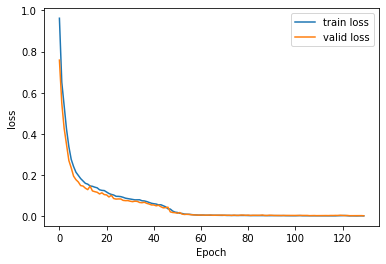

8/8 [==============================] - 1s 4ms/step
Threshold setting...


,Reconstruction_error,True_class
count,249.000000,249.0
mean,0.002437,0.0
std,0.010828,0.0
min,0.000078,0.0
25%,0.000490,0.0
50%,0.000763,0.0
75%,0.001237,0.0
max,0.151656,0.0


Threshold for this process is.. : 0.03253405361325141
Epoch 1/130
23/23 [==============================] - 7s 63ms/step - loss: 0.9758 - val_loss: 0.8630
Epoch 2/130
23/23 [==============================] - 0s 11ms/step - loss: 0.7181 - val_loss: 0.6162
Epoch 3/130
23/23 [==============================] - 0s 13ms/step - loss: 0.6296 - val_loss: 0.5094
Epoch 4/130
23/23 [==============================] - 0s 10ms/step - loss: 0.4805 - val_loss: 0.4082
Epoch 5/130
23/23 [==============================] - 0s 13ms/step - loss: 0.3987 - val_loss: 0.3307
Epoch 6/130
23/23 [==============================] - 0s 17ms/step - loss: 0.3510 - val_loss: 0.2794
Epoch 7/130
23/23 [==============================] - 0s 13ms/step - loss: 0.2949 - val_loss: 0.2378
Epoch 8/130
23/23 [==============================] - 0s 14ms/step - loss: 0.2598 - val_loss: 0.2123
Epoch 9/130
23/23 [==============================] - 0s 13ms/step - loss: 0.2558 - val_loss: 0.2206
Epoch 10/130
23/23 [==========================

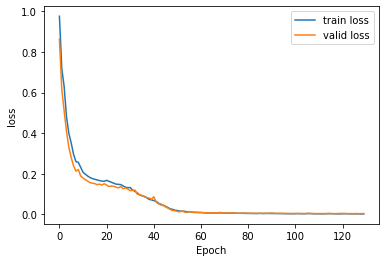

7/7 [==============================] - 1s 3ms/step
Threshold setting...


,Reconstruction_error,True_class
count,213.000000,213.0
mean,0.003109,0.0
std,0.014040,0.0
min,0.000069,0.0
25%,0.000393,0.0
50%,0.000674,0.0
75%,0.001330,0.0
max,0.153434,0.0


Threshold for this process is.. : 0.07284140460001277
Epoch 1/130
23/23 [==============================] - 7s 45ms/step - loss: 0.9782 - val_loss: 0.8287
Epoch 2/130
23/23 [==============================] - 0s 11ms/step - loss: 0.8487 - val_loss: 0.6186
Epoch 3/130
23/23 [==============================] - 0s 11ms/step - loss: 0.6132 - val_loss: 0.5190
Epoch 4/130
23/23 [==============================] - 0s 11ms/step - loss: 0.4922 - val_loss: 0.4113
Epoch 5/130
23/23 [==============================] - 0s 11ms/step - loss: 0.4123 - val_loss: 0.3565
Epoch 6/130
23/23 [==============================] - 0s 13ms/step - loss: 0.3518 - val_loss: 0.3190
Epoch 7/130
23/23 [==============================] - 0s 12ms/step - loss: 0.3131 - val_loss: 0.2811
Epoch 8/130
23/23 [==============================] - 0s 11ms/step - loss: 0.2651 - val_loss: 0.2330
Epoch 9/130
23/23 [==============================] - 0s 11ms/step - loss: 0.2218 - val_loss: 0.1928
Epoch 10/130
23/23 [==========================

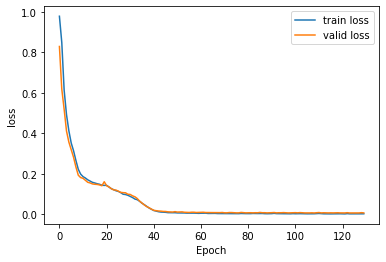

7/7 [==============================] - 1s 4ms/step
Threshold setting...


,Reconstruction_error,True_class
count,213.000000,213.0
mean,0.006553,0.0
std,0.028774,0.0
min,0.000166,0.0
25%,0.000810,0.0
50%,0.001274,0.0
75%,0.002286,0.0
max,0.367286,0.0


Threshold for this process is.. : 0.1035816350100477
Epoch 1/130
26/26 [==============================] - 7s 45ms/step - loss: 0.9573 - val_loss: 0.8268
Epoch 2/130
26/26 [==============================] - 0s 11ms/step - loss: 0.6496 - val_loss: 0.6269
Epoch 3/130
26/26 [==============================] - 0s 11ms/step - loss: 0.4989 - val_loss: 0.5294
Epoch 4/130
26/26 [==============================] - 0s 11ms/step - loss: 0.3769 - val_loss: 0.3719
Epoch 5/130
26/26 [==============================] - 0s 11ms/step - loss: 0.3135 - val_loss: 0.2908
Epoch 6/130
26/26 [==============================] - 0s 14ms/step - loss: 0.2594 - val_loss: 0.2930
Epoch 7/130
26/26 [==============================] - 0s 11ms/step - loss: 0.2226 - val_loss: 0.2788
Epoch 8/130
26/26 [==============================] - 0s 11ms/step - loss: 0.2032 - val_loss: 0.2808
Epoch 9/130
26/26 [==============================] - 0s 11ms/step - loss: 0.1851 - val_loss: 0.2867
Epoch 10/130
26/26 [===========================

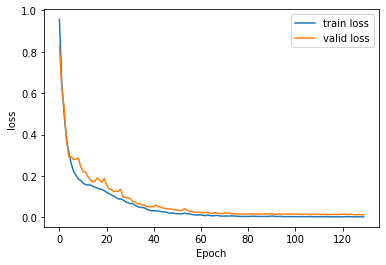

8/8 [==============================] - 1s 3ms/step
Threshold setting...


,Reconstruction_error,True_class
count,249.000000,249.0
mean,0.012401,0.0
std,0.053323,0.0
min,0.000091,0.0
25%,0.000826,0.0
50%,0.001160,0.0
75%,0.002524,0.0
max,0.530738,0.0


Threshold for this process is.. : 0.3057822973488092
Epoch 1/130
26/26 [==============================] - 7s 44ms/step - loss: 0.9622 - val_loss: 0.7483
Epoch 2/130
26/26 [==============================] - 0s 11ms/step - loss: 0.6371 - val_loss: 0.5000
Epoch 3/130
26/26 [==============================] - 0s 11ms/step - loss: 0.5099 - val_loss: 0.3982
Epoch 4/130
26/26 [==============================] - 0s 11ms/step - loss: 0.3984 - val_loss: 0.2990
Epoch 5/130
26/26 [==============================] - 0s 11ms/step - loss: 0.3046 - val_loss: 0.2401
Epoch 6/130
26/26 [==============================] - 0s 11ms/step - loss: 0.2533 - val_loss: 0.2090
Epoch 7/130
26/26 [==============================] - 0s 11ms/step - loss: 0.2125 - val_loss: 0.1657
Epoch 8/130
26/26 [==============================] - 0s 11ms/step - loss: 0.1936 - val_loss: 0.1511
Epoch 9/130
26/26 [==============================] - 0s 11ms/step - loss: 0.1742 - val_loss: 0.1434
Epoch 10/130
26/26 [===========================

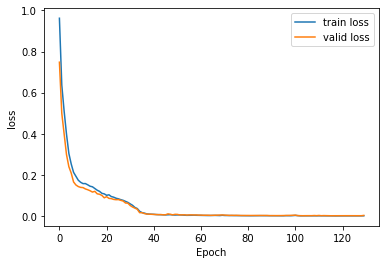

8/8 [==============================] - 1s 4ms/step
Threshold setting...


,Reconstruction_error,True_class
count,249.000000,249.0
mean,0.003135,0.0
std,0.005035,0.0
min,0.000545,0.0
25%,0.001301,0.0
50%,0.001791,0.0
75%,0.002802,0.0
max,0.050399,0.0


Threshold for this process is.. : 0.026583469837733454
Epoch 1/130
24/24 [==============================] - 7s 46ms/step - loss: 0.9770 - val_loss: 0.7550
Epoch 2/130
24/24 [==============================] - 0s 11ms/step - loss: 1.8089 - val_loss: 0.5194
Epoch 3/130
24/24 [==============================] - 0s 12ms/step - loss: 0.6119 - val_loss: 0.4856
Epoch 4/130
24/24 [==============================] - 0s 12ms/step - loss: 0.5159 - val_loss: 0.3765
Epoch 5/130
24/24 [==============================] - 0s 12ms/step - loss: 0.4236 - val_loss: 0.3256
Epoch 6/130
24/24 [==============================] - 0s 13ms/step - loss: 0.3787 - val_loss: 0.2966
Epoch 7/130
24/24 [==============================] - 0s 13ms/step - loss: 0.3373 - val_loss: 0.2676
Epoch 8/130
24/24 [==============================] - 0s 13ms/step - loss: 0.2915 - val_loss: 0.2295
Epoch 9/130
24/24 [==============================] - 0s 12ms/step - loss: 0.2461 - val_loss: 0.1928
Epoch 10/130
24/24 [=========================

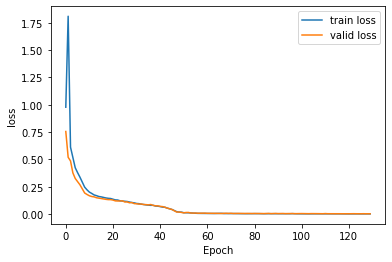

8/8 [==============================] - 1s 4ms/step
Threshold setting...


,Reconstruction_error,True_class
count,249.000000,249.0
mean,0.002703,0.0
std,0.008502,0.0
min,0.000119,0.0
25%,0.000473,0.0
50%,0.000776,0.0
75%,0.001524,0.0
max,0.087510,0.0


Threshold for this process is.. : 0.043138849044108155
Epoch 1/130
24/24 [==============================] - 7s 46ms/step - loss: 0.9707 - val_loss: 0.9688
Epoch 2/130
24/24 [==============================] - 0s 11ms/step - loss: 0.6492 - val_loss: 0.6686
Epoch 3/130
24/24 [==============================] - 0s 11ms/step - loss: 0.5081 - val_loss: 0.5708
Epoch 4/130
24/24 [==============================] - 0s 12ms/step - loss: 0.4164 - val_loss: 0.4490
Epoch 5/130
24/24 [==============================] - 0s 11ms/step - loss: 0.3199 - val_loss: 0.3460
Epoch 6/130
24/24 [==============================] - 0s 12ms/step - loss: 0.2566 - val_loss: 0.3494
Epoch 7/130
24/24 [==============================] - 0s 12ms/step - loss: 0.2155 - val_loss: 0.3147
Epoch 8/130
24/24 [==============================] - 0s 12ms/step - loss: 0.1897 - val_loss: 0.3268
Epoch 9/130
24/24 [==============================] - 0s 11ms/step - loss: 0.1798 - val_loss: 0.2792
Epoch 10/130
24/24 [=========================

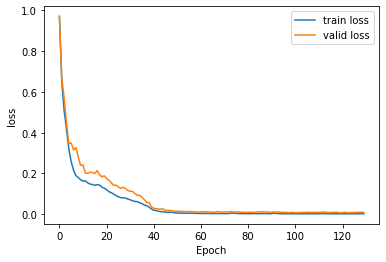

8/8 [==============================] - 1s 4ms/step
Threshold setting...


,Reconstruction_error,True_class
count,249.000000,249.0
mean,0.008674,0.0
std,0.040712,0.0
min,0.000223,0.0
25%,0.001238,0.0
50%,0.002131,0.0
75%,0.003743,0.0
max,0.532735,0.0


Threshold for this process is.. : 0.12567294642203508
Epoch 1/130
24/24 [==============================] - 7s 59ms/step - loss: 0.9745 - val_loss: 0.9594
Epoch 2/130
24/24 [==============================] - 0s 14ms/step - loss: 0.7165 - val_loss: 0.6647
Epoch 3/130
24/24 [==============================] - 0s 14ms/step - loss: 0.5472 - val_loss: 0.5377
Epoch 4/130
24/24 [==============================] - 0s 14ms/step - loss: 0.4398 - val_loss: 0.4300
Epoch 5/130
24/24 [==============================] - 0s 14ms/step - loss: 0.3460 - val_loss: 0.3461
Epoch 6/130
24/24 [==============================] - 0s 13ms/step - loss: 0.2792 - val_loss: 0.3003
Epoch 7/130
24/24 [==============================] - 0s 14ms/step - loss: 0.2320 - val_loss: 0.2619
Epoch 8/130
24/24 [==============================] - 0s 14ms/step - loss: 0.2165 - val_loss: 0.2592
Epoch 9/130
24/24 [==============================] - 0s 16ms/step - loss: 0.1945 - val_loss: 0.2251
Epoch 10/130
24/24 [==========================

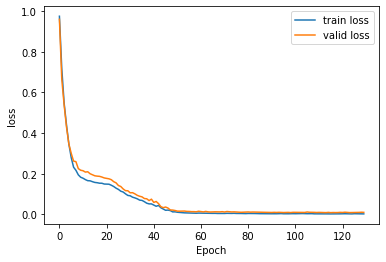

8/8 [==============================] - 1s 5ms/step
Threshold setting...


,Reconstruction_error,True_class
count,249.000000,249.0
mean,0.009722,0.0
std,0.036160,0.0
min,0.000056,0.0
25%,0.000928,0.0
50%,0.001582,0.0
75%,0.003058,0.0
max,0.336526,0.0


Threshold for this process is.. : 0.19853964158867038
Epoch 1/130
24/24 [==============================] - 7s 48ms/step - loss: 0.9689 - val_loss: 0.8590
Epoch 2/130
24/24 [==============================] - 0s 14ms/step - loss: 0.6893 - val_loss: 0.5556
Epoch 3/130
24/24 [==============================] - 0s 14ms/step - loss: 0.5158 - val_loss: 0.4713
Epoch 4/130
24/24 [==============================] - 0s 14ms/step - loss: 0.4135 - val_loss: 0.3428
Epoch 5/130
24/24 [==============================] - 0s 13ms/step - loss: 0.2933 - val_loss: 0.2607
Epoch 6/130
24/24 [==============================] - 0s 14ms/step - loss: 0.2482 - val_loss: 0.2359
Epoch 7/130
24/24 [==============================] - 0s 15ms/step - loss: 0.2162 - val_loss: 0.2037
Epoch 8/130
24/24 [==============================] - 0s 13ms/step - loss: 0.1937 - val_loss: 0.1852
Epoch 9/130
24/24 [==============================] - 0s 14ms/step - loss: 0.1829 - val_loss: 0.1733
Epoch 10/130
24/24 [==========================

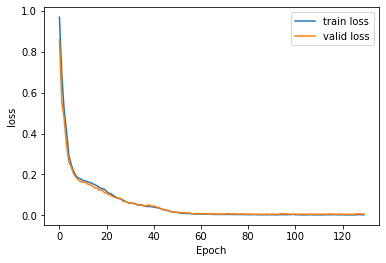

8/8 [==============================] - 1s 4ms/step
Threshold setting...


,Reconstruction_error,True_class
count,249.000000,249.0
mean,0.006834,0.0
std,0.022889,0.0
min,0.000239,0.0
25%,0.000994,0.0
50%,0.001896,0.0
75%,0.003569,0.0
max,0.246396,0.0


Threshold for this process is.. : 0.1005184142873193
Epoch 1/130
24/24 [==============================] - 7s 47ms/step - loss: 0.9735 - val_loss: 0.8053
Epoch 2/130
24/24 [==============================] - 0s 14ms/step - loss: 0.6968 - val_loss: 0.5480
Epoch 3/130
24/24 [==============================] - 0s 17ms/step - loss: 0.5466 - val_loss: 0.4534
Epoch 4/130
24/24 [==============================] - 0s 14ms/step - loss: 0.4679 - val_loss: 0.3780
Epoch 5/130
24/24 [==============================] - 0s 16ms/step - loss: 0.3799 - val_loss: 0.2992
Epoch 6/130
24/24 [==============================] - 0s 14ms/step - loss: 0.3053 - val_loss: 0.2435
Epoch 7/130
24/24 [==============================] - 0s 15ms/step - loss: 0.2582 - val_loss: 0.2158
Epoch 8/130
24/24 [==============================] - 0s 15ms/step - loss: 0.2251 - val_loss: 0.1859
Epoch 9/130
24/24 [==============================] - 0s 14ms/step - loss: 0.2056 - val_loss: 0.1798
Epoch 10/130
24/24 [===========================

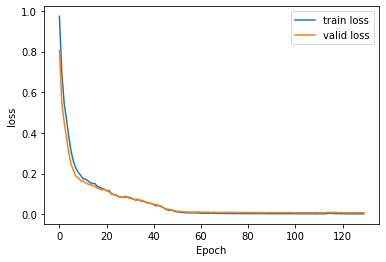

8/8 [==============================] - 1s 6ms/step
Threshold setting...


,Reconstruction_error,True_class
count,249.000000,249.0
mean,0.007834,0.0
std,0.050481,0.0
min,0.000054,0.0
25%,0.000521,0.0
50%,0.001121,0.0
75%,0.001864,0.0
max,0.702003,0.0


Threshold for this process is.. : 0.14498919080733044
Epoch 1/130
23/23 [==============================] - 7s 51ms/step - loss: 0.9728 - val_loss: 0.8631
Epoch 2/130
23/23 [==============================] - 0s 17ms/step - loss: 0.7107 - val_loss: 0.6043
Epoch 3/130
23/23 [==============================] - 0s 18ms/step - loss: 0.5494 - val_loss: 0.4852
Epoch 4/130
23/23 [==============================] - 0s 19ms/step - loss: 0.4692 - val_loss: 0.4047
Epoch 5/130
23/23 [==============================] - 0s 17ms/step - loss: 0.3668 - val_loss: 0.3264
Epoch 6/130
23/23 [==============================] - 0s 16ms/step - loss: 0.2945 - val_loss: 0.2677
Epoch 7/130
23/23 [==============================] - 0s 16ms/step - loss: 0.2523 - val_loss: 0.2606
Epoch 8/130
23/23 [==============================] - 0s 17ms/step - loss: 0.2891 - val_loss: 0.2739
Epoch 9/130
23/23 [==============================] - 0s 17ms/step - loss: 0.2501 - val_loss: 0.2223
Epoch 10/130
23/23 [==========================

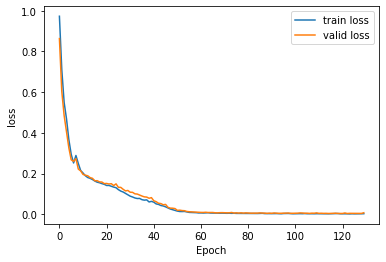

7/7 [==============================] - 1s 5ms/step
Threshold setting...


,Reconstruction_error,True_class
count,213.000000,213.0
mean,0.007876,0.0
std,0.013331,0.0
min,0.000947,0.0
25%,0.002481,0.0
50%,0.004110,0.0
75%,0.008361,0.0
max,0.146666,0.0


Threshold for this process is.. : 0.05569941405324499
Epoch 1/130
23/23 [==============================] - 7s 47ms/step - loss: 0.9723 - val_loss: 0.7651
Epoch 2/130
23/23 [==============================] - 0s 12ms/step - loss: 0.7588 - val_loss: 0.5712
Epoch 3/130
23/23 [==============================] - 0s 14ms/step - loss: 0.6070 - val_loss: 0.4845
Epoch 4/130
23/23 [==============================] - 0s 13ms/step - loss: 0.5282 - val_loss: 0.4281
Epoch 5/130
23/23 [==============================] - 0s 12ms/step - loss: 0.4533 - val_loss: 0.3647
Epoch 6/130
23/23 [==============================] - 0s 12ms/step - loss: 0.3920 - val_loss: 0.3182
Epoch 7/130
23/23 [==============================] - 0s 12ms/step - loss: 0.3344 - val_loss: 0.2735
Epoch 8/130
23/23 [==============================] - 0s 12ms/step - loss: 0.2900 - val_loss: 0.2468
Epoch 9/130
23/23 [==============================] - 0s 12ms/step - loss: 0.2544 - val_loss: 0.2201
Epoch 10/130
23/23 [==========================

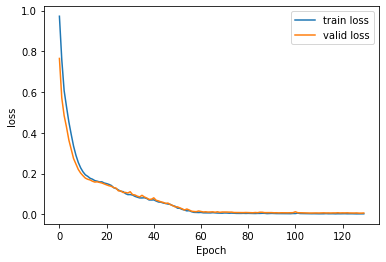

7/7 [==============================] - 1s 4ms/step
Threshold setting...


,Reconstruction_error,True_class
count,213.000000,213.0
mean,0.006382,0.0
std,0.025896,0.0
min,0.000205,0.0
25%,0.000879,0.0
50%,0.001334,0.0
75%,0.002529,0.0
max,0.302696,0.0


Threshold for this process is.. : 0.09065291612000614
Epoch 1/130
21/21 [==============================] - 7s 60ms/step - loss: 0.9807 - val_loss: 0.9561
Epoch 2/130
21/21 [==============================] - 0s 12ms/step - loss: 0.7340 - val_loss: 0.5942
Epoch 3/130
21/21 [==============================] - 0s 12ms/step - loss: 0.5705 - val_loss: 0.5605
Epoch 4/130
21/21 [==============================] - 0s 12ms/step - loss: 0.4577 - val_loss: 0.4544
Epoch 5/130
21/21 [==============================] - 0s 12ms/step - loss: 0.3705 - val_loss: 0.3911
Epoch 6/130
21/21 [==============================] - 0s 12ms/step - loss: 0.3089 - val_loss: 0.3339
Epoch 7/130
21/21 [==============================] - 0s 12ms/step - loss: 0.2730 - val_loss: 0.2970
Epoch 8/130
21/21 [==============================] - 0s 12ms/step - loss: 0.2397 - val_loss: 0.2662
Epoch 9/130
21/21 [==============================] - 0s 11ms/step - loss: 0.2219 - val_loss: 0.2542
Epoch 10/130
21/21 [==========================

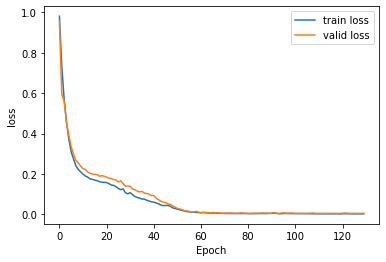

7/7 [==============================] - 1s 4ms/step
Threshold setting...


,Reconstruction_error,True_class
count,213.000000,213.0
mean,0.005676,0.0
std,0.016957,0.0
min,0.000228,0.0
25%,0.000907,0.0
50%,0.001473,0.0
75%,0.003129,0.0
max,0.151284,0.0


Threshold for this process is.. : 0.07100717552533471
Epoch 1/130
23/23 [==============================] - 7s 49ms/step - loss: 0.9825 - val_loss: 0.9022
Epoch 2/130
23/23 [==============================] - 0s 14ms/step - loss: 0.7561 - val_loss: 0.6272
Epoch 3/130
23/23 [==============================] - 0s 15ms/step - loss: 0.6147 - val_loss: 0.5150
Epoch 4/130
23/23 [==============================] - 0s 15ms/step - loss: 0.5219 - val_loss: 0.4581
Epoch 5/130
23/23 [==============================] - 0s 15ms/step - loss: 0.4547 - val_loss: 0.3788
Epoch 6/130
23/23 [==============================] - 0s 15ms/step - loss: 0.3807 - val_loss: 0.3072
Epoch 7/130
23/23 [==============================] - 0s 15ms/step - loss: 0.3173 - val_loss: 0.2424
Epoch 8/130
23/23 [==============================] - 0s 17ms/step - loss: 0.2598 - val_loss: 0.2083
Epoch 9/130
23/23 [==============================] - 0s 16ms/step - loss: 0.2269 - val_loss: 0.1835
Epoch 10/130
23/23 [==========================

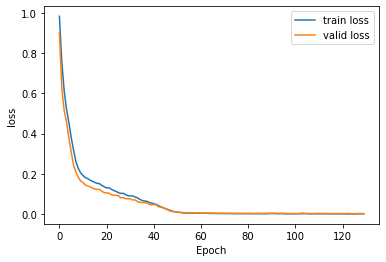

7/7 [==============================] - 1s 5ms/step
Threshold setting...


,Reconstruction_error,True_class
count,213.000000,213.0
mean,0.002529,0.0
std,0.007132,0.0
min,0.000045,0.0
25%,0.000389,0.0
50%,0.000655,0.0
75%,0.001458,0.0
max,0.048949,0.0


Threshold for this process is.. : 0.045200081875425464
Epoch 1/130
21/21 [==============================] - 7s 51ms/step - loss: 0.9806 - val_loss: 1.0131
Epoch 2/130
21/21 [==============================] - 0s 18ms/step - loss: 2.9826 - val_loss: 0.6789
Epoch 3/130
21/21 [==============================] - 0s 12ms/step - loss: 0.6302 - val_loss: 0.7158
Epoch 4/130
21/21 [==============================] - 0s 13ms/step - loss: 0.5931 - val_loss: 0.5959
Epoch 5/130
21/21 [==============================] - 0s 13ms/step - loss: 0.5024 - val_loss: 0.5427
Epoch 6/130
21/21 [==============================] - 0s 13ms/step - loss: 0.4411 - val_loss: 0.4695
Epoch 7/130
21/21 [==============================] - 0s 13ms/step - loss: 0.3800 - val_loss: 0.4201
Epoch 8/130
21/21 [==============================] - 0s 20ms/step - loss: 0.3316 - val_loss: 0.3693
Epoch 9/130
21/21 [==============================] - 0s 16ms/step - loss: 0.2858 - val_loss: 0.3172
Epoch 10/130
21/21 [=========================

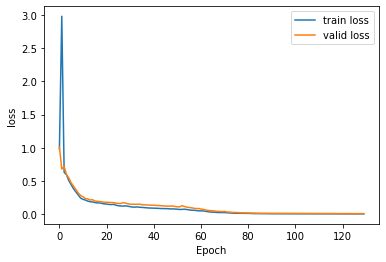

7/7 [==============================] - 1s 6ms/step
Threshold setting...


,Reconstruction_error,True_class
count,213.000000,213.0
mean,0.006193,0.0
std,0.019985,0.0
min,0.000160,0.0
25%,0.000628,0.0
50%,0.001185,0.0
75%,0.001885,0.0
max,0.148096,0.0


Threshold for this process is.. : 0.12055363842381882
Epoch 1/130
20/20 [==============================] - 7s 50ms/step - loss: 0.9865 - val_loss: 0.8807
Epoch 2/130
20/20 [==============================] - 0s 13ms/step - loss: 0.7920 - val_loss: 0.5462
Epoch 3/130
20/20 [==============================] - 0s 13ms/step - loss: 0.5935 - val_loss: 0.4678
Epoch 4/130
20/20 [==============================] - 0s 12ms/step - loss: 0.5091 - val_loss: 0.4101
Epoch 5/130
20/20 [==============================] - 0s 12ms/step - loss: 0.4418 - val_loss: 0.3438
Epoch 6/130
20/20 [==============================] - 0s 12ms/step - loss: 0.3887 - val_loss: 0.3087
Epoch 7/130
20/20 [==============================] - 0s 12ms/step - loss: 0.3446 - val_loss: 0.2657
Epoch 8/130
20/20 [==============================] - 0s 12ms/step - loss: 0.2983 - val_loss: 0.2308
Epoch 9/130
20/20 [==============================] - 0s 12ms/step - loss: 0.2662 - val_loss: 0.2193
Epoch 10/130
20/20 [==========================

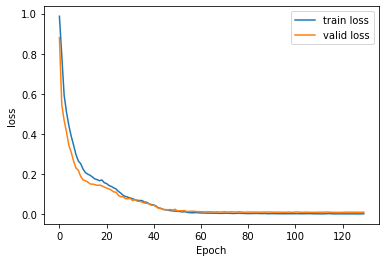

6/6 [==============================] - 1s 4ms/step
Threshold setting...


,Reconstruction_error,True_class
count,177.000000,177.0
mean,0.010671,0.0
std,0.057997,0.0
min,0.000120,0.0
25%,0.001146,0.0
50%,0.001867,0.0
75%,0.003402,0.0
max,0.611206,0.0


Threshold for this process is.. : 0.18382474319117947
Epoch 1/130
18/18 [==============================] - 7s 55ms/step - loss: 0.9798 - val_loss: 0.8977
Epoch 2/130
18/18 [==============================] - 0s 14ms/step - loss: 0.7293 - val_loss: 0.7702
Epoch 3/130
18/18 [==============================] - 0s 14ms/step - loss: 0.5652 - val_loss: 0.5245
Epoch 4/130
18/18 [==============================] - 0s 14ms/step - loss: 0.4651 - val_loss: 0.4369
Epoch 5/130
18/18 [==============================] - 0s 13ms/step - loss: 0.3804 - val_loss: 0.3761
Epoch 6/130
18/18 [==============================] - 0s 13ms/step - loss: 0.3252 - val_loss: 0.3164
Epoch 7/130
18/18 [==============================] - 0s 13ms/step - loss: 0.2727 - val_loss: 0.2823
Epoch 8/130
18/18 [==============================] - 0s 13ms/step - loss: 0.2366 - val_loss: 0.2599
Epoch 9/130
18/18 [==============================] - 0s 13ms/step - loss: 0.2160 - val_loss: 0.2443
Epoch 10/130
18/18 [==========================

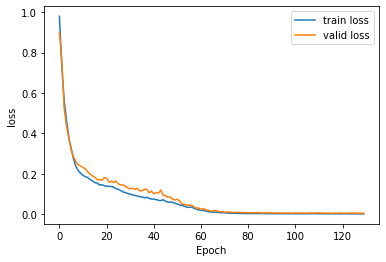

6/6 [==============================] - 1s 4ms/step
Threshold setting...


,Reconstruction_error,True_class
count,177.000000,177.0
mean,0.005053,0.0
std,0.018597,0.0
min,0.000066,0.0
25%,0.000485,0.0
50%,0.000829,0.0
75%,0.001822,0.0
max,0.218052,0.0


Threshold for this process is.. : 0.0585275961381276
Epoch 1/130
20/20 [==============================] - 6s 47ms/step - loss: 0.9818 - val_loss: 0.9431
Epoch 2/130
20/20 [==============================] - 0s 11ms/step - loss: 0.7542 - val_loss: 0.6173
Epoch 3/130
20/20 [==============================] - 0s 11ms/step - loss: 0.5643 - val_loss: 0.5271
Epoch 4/130
20/20 [==============================] - 0s 12ms/step - loss: 0.4899 - val_loss: 0.4502
Epoch 5/130
20/20 [==============================] - 0s 11ms/step - loss: 0.3959 - val_loss: 0.3755
Epoch 6/130
20/20 [==============================] - 0s 12ms/step - loss: 0.3309 - val_loss: 0.3336
Epoch 7/130
20/20 [==============================] - 0s 12ms/step - loss: 0.2874 - val_loss: 0.2996
Epoch 8/130
20/20 [==============================] - 0s 11ms/step - loss: 0.2645 - val_loss: 0.2857
Epoch 9/130
20/20 [==============================] - 0s 11ms/step - loss: 0.2419 - val_loss: 0.2621
Epoch 10/130
20/20 [===========================

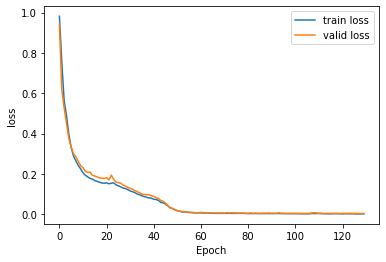

6/6 [==============================] - 1s 4ms/step
Threshold setting...


,Reconstruction_error,True_class
count,177.000000,177.0
mean,0.004393,0.0
std,0.011831,0.0
min,0.000161,0.0
25%,0.000516,0.0
50%,0.000899,0.0
75%,0.001610,0.0
max,0.089603,0.0


Threshold for this process is.. : 0.05741812881973223
Epoch 1/130
21/21 [==============================] - 7s 65ms/step - loss: 0.9795 - val_loss: 0.8484
Epoch 2/130
21/21 [==============================] - 0s 16ms/step - loss: 0.7413 - val_loss: 0.5357
Epoch 3/130
21/21 [==============================] - 0s 15ms/step - loss: 0.5662 - val_loss: 0.4551
Epoch 4/130
21/21 [==============================] - 0s 15ms/step - loss: 0.4861 - val_loss: 0.3821
Epoch 5/130
21/21 [==============================] - 0s 15ms/step - loss: 0.3850 - val_loss: 0.2981
Epoch 6/130
21/21 [==============================] - 0s 15ms/step - loss: 0.3109 - val_loss: 0.2408
Epoch 7/130
21/21 [==============================] - 0s 15ms/step - loss: 0.2680 - val_loss: 0.2338
Epoch 8/130
21/21 [==============================] - 0s 15ms/step - loss: 0.2515 - val_loss: 0.1990
Epoch 9/130
21/21 [==============================] - 0s 15ms/step - loss: 0.2067 - val_loss: 0.1620
Epoch 10/130
21/21 [==========================

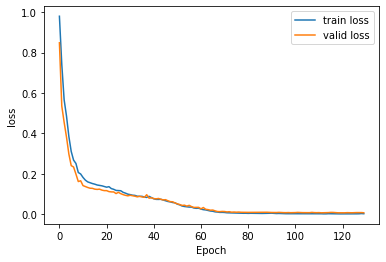

7/7 [==============================] - 1s 4ms/step
Threshold setting...


,Reconstruction_error,True_class
count,213.000000,213.0
mean,0.007703,0.0
std,0.033458,0.0
min,0.000123,0.0
25%,0.001104,0.0
50%,0.001501,0.0
75%,0.002317,0.0
max,0.304855,0.0


Threshold for this process is.. : 0.1589003546456283
Epoch 1/130
20/20 [==============================] - 7s 56ms/step - loss: 0.9774 - val_loss: 0.7174
Epoch 2/130
20/20 [==============================] - 0s 16ms/step - loss: 0.8172 - val_loss: 0.4972
Epoch 3/130
20/20 [==============================] - 0s 16ms/step - loss: 0.6413 - val_loss: 0.4554
Epoch 4/130
20/20 [==============================] - 0s 16ms/step - loss: 0.5458 - val_loss: 0.3816
Epoch 5/130
20/20 [==============================] - 0s 16ms/step - loss: 0.4717 - val_loss: 0.3268
Epoch 6/130
20/20 [==============================] - 0s 16ms/step - loss: 0.3951 - val_loss: 0.2815
Epoch 7/130
20/20 [==============================] - 0s 18ms/step - loss: 0.3384 - val_loss: 0.2430
Epoch 8/130
20/20 [==============================] - 0s 18ms/step - loss: 0.2889 - val_loss: 0.1985
Epoch 9/130
20/20 [==============================] - 0s 16ms/step - loss: 0.2453 - val_loss: 0.1779
Epoch 10/130
20/20 [===========================

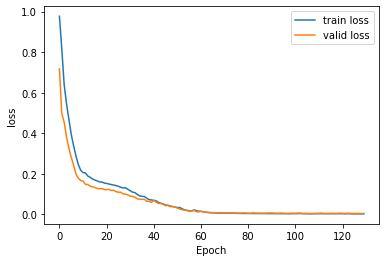

6/6 [==============================] - 1s 4ms/step
Threshold setting...


,Reconstruction_error,True_class
count,177.000000,177.0
mean,0.004022,0.0
std,0.020751,0.0
min,0.000132,0.0
25%,0.000516,0.0
50%,0.000937,0.0
75%,0.001507,0.0
max,0.263144,0.0


Threshold for this process is.. : 0.05005697150624484
Epoch 1/130
21/21 [==============================] - 6s 49ms/step - loss: 0.9875 - val_loss: 0.9644
Epoch 2/130
21/21 [==============================] - 0s 15ms/step - loss: 0.8298 - val_loss: 0.9305
Epoch 3/130
21/21 [==============================] - 0s 15ms/step - loss: 0.6304 - val_loss: 0.6166
Epoch 4/130
21/21 [==============================] - 0s 16ms/step - loss: 0.5384 - val_loss: 0.5030
Epoch 5/130
21/21 [==============================] - 0s 18ms/step - loss: 0.4526 - val_loss: 0.4215
Epoch 6/130
21/21 [==============================] - 0s 18ms/step - loss: 0.3780 - val_loss: 0.3436
Epoch 7/130
21/21 [==============================] - 0s 23ms/step - loss: 0.3262 - val_loss: 0.3292
Epoch 8/130
21/21 [==============================] - 0s 21ms/step - loss: 0.2890 - val_loss: 0.2731
Epoch 9/130
21/21 [==============================] - 0s 19ms/step - loss: 0.2613 - val_loss: 0.2554
Epoch 10/130
21/21 [==========================

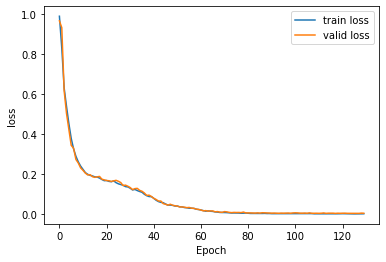

7/7 [==============================] - 1s 4ms/step
Threshold setting...


,Reconstruction_error,True_class
count,213.000000,213.0
mean,0.005022,0.0
std,0.011385,0.0
min,0.000384,0.0
25%,0.001077,0.0
50%,0.001614,0.0
75%,0.003350,0.0
max,0.092675,0.0


Threshold for this process is.. : 0.05554393788139149
Epoch 1/130
21/21 [==============================] - 6s 50ms/step - loss: 0.9842 - val_loss: 1.0357
Epoch 2/130
21/21 [==============================] - 0s 17ms/step - loss: 0.7354 - val_loss: 0.7310
Epoch 3/130
21/21 [==============================] - 0s 19ms/step - loss: 0.5514 - val_loss: 0.5765
Epoch 4/130
21/21 [==============================] - 0s 19ms/step - loss: 0.4556 - val_loss: 0.4538
Epoch 5/130
21/21 [==============================] - 0s 20ms/step - loss: 0.3339 - val_loss: 0.3450
Epoch 6/130
21/21 [==============================] - 0s 19ms/step - loss: 0.2768 - val_loss: 0.3049
Epoch 7/130
21/21 [==============================] - 0s 20ms/step - loss: 0.2375 - val_loss: 0.2703
Epoch 8/130
21/21 [==============================] - 0s 19ms/step - loss: 0.2076 - val_loss: 0.2390
Epoch 9/130
21/21 [==============================] - 0s 19ms/step - loss: 0.1904 - val_loss: 0.2209
Epoch 10/130
21/21 [==========================

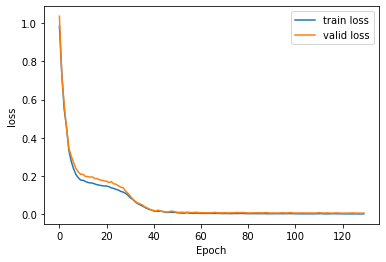

7/7 [==============================] - 1s 4ms/step
Threshold setting...


,Reconstruction_error,True_class
count,213.000000,213.0
mean,0.006063,0.0
std,0.020313,0.0
min,0.000357,0.0
25%,0.001018,0.0
50%,0.001684,0.0
75%,0.003070,0.0
max,0.177275,0.0


Threshold for this process is.. : 0.12514097588126386
Epoch 1/130
23/23 [==============================] - 6s 47ms/step - loss: 0.9771 - val_loss: 0.9873
Epoch 2/130
23/23 [==============================] - 0s 14ms/step - loss: 0.7820 - val_loss: 0.7206
Epoch 3/130
23/23 [==============================] - 0s 16ms/step - loss: 0.6168 - val_loss: 0.6185
Epoch 4/130
23/23 [==============================] - 0s 17ms/step - loss: 0.5194 - val_loss: 0.5508
Epoch 5/130
23/23 [==============================] - 0s 18ms/step - loss: 0.4365 - val_loss: 0.4457
Epoch 6/130
23/23 [==============================] - 0s 18ms/step - loss: 0.3877 - val_loss: 0.4110
Epoch 7/130
23/23 [==============================] - 0s 18ms/step - loss: 0.3629 - val_loss: 0.3758
Epoch 8/130
23/23 [==============================] - 0s 19ms/step - loss: 0.3193 - val_loss: 0.3177
Epoch 9/130
23/23 [==============================] - 0s 19ms/step - loss: 0.2820 - val_loss: 0.2891
Epoch 10/130
23/23 [==========================

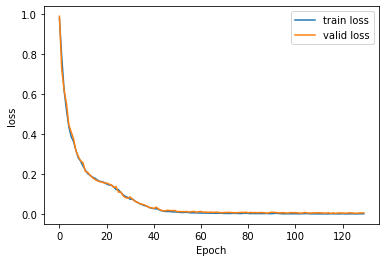

7/7 [==============================] - 1s 5ms/step
Threshold setting...


,Reconstruction_error,True_class
count,213.000000,213.0
mean,0.008227,0.0
std,0.028053,0.0
min,0.000383,0.0
25%,0.001524,0.0
50%,0.001905,0.0
75%,0.002696,0.0
max,0.268089,0.0


Threshold for this process is.. : 0.17488517964865088
Epoch 1/130
23/23 [==============================] - 6s 57ms/step - loss: 0.9830 - val_loss: 0.9695
Epoch 2/130
23/23 [==============================] - 0s 14ms/step - loss: 0.6963 - val_loss: 0.6554
Epoch 3/130
23/23 [==============================] - 0s 16ms/step - loss: 0.5458 - val_loss: 0.5222
Epoch 4/130
23/23 [==============================] - 0s 17ms/step - loss: 0.4543 - val_loss: 0.3994
Epoch 5/130
23/23 [==============================] - 0s 17ms/step - loss: 0.3392 - val_loss: 0.2945
Epoch 6/130
23/23 [==============================] - 0s 17ms/step - loss: 0.2666 - val_loss: 0.2508
Epoch 7/130
23/23 [==============================] - 0s 17ms/step - loss: 0.2263 - val_loss: 0.2059
Epoch 8/130
23/23 [==============================] - 0s 17ms/step - loss: 0.1971 - val_loss: 0.1793
Epoch 9/130
23/23 [==============================] - 0s 17ms/step - loss: 0.1791 - val_loss: 0.1703
Epoch 10/130
23/23 [==========================

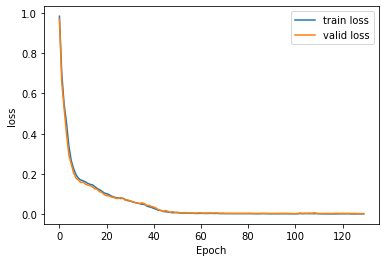

7/7 [==============================] - 1s 5ms/step
Threshold setting...


,Reconstruction_error,True_class
count,213.000000,213.0
mean,0.003222,0.0
std,0.011699,0.0
min,0.000073,0.0
25%,0.000448,0.0
50%,0.000851,0.0
75%,0.001693,0.0
max,0.123883,0.0


Threshold for this process is.. : 0.03974005754269116
Epoch 1/130
24/24 [==============================] - 6s 43ms/step - loss: 0.9735 - val_loss: 0.8332
Epoch 2/130
24/24 [==============================] - 0s 13ms/step - loss: 0.7277 - val_loss: 0.5973
Epoch 3/130
24/24 [==============================] - 0s 15ms/step - loss: 0.5551 - val_loss: 0.5019
Epoch 4/130
24/24 [==============================] - 0s 16ms/step - loss: 0.4758 - val_loss: 0.4188
Epoch 5/130
24/24 [==============================] - 0s 19ms/step - loss: 0.3674 - val_loss: 0.3357
Epoch 6/130
24/24 [==============================] - 1s 21ms/step - loss: 0.3339 - val_loss: 0.3267
Epoch 7/130
24/24 [==============================] - 0s 20ms/step - loss: 0.2889 - val_loss: 0.2698
Epoch 8/130
24/24 [==============================] - 0s 18ms/step - loss: 0.2455 - val_loss: 0.2410
Epoch 9/130
24/24 [==============================] - 0s 20ms/step - loss: 0.2166 - val_loss: 0.2190
Epoch 10/130
24/24 [==========================

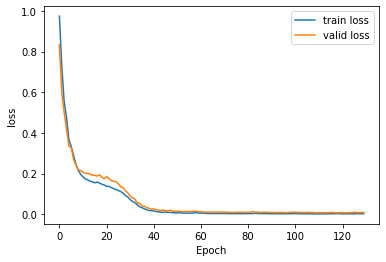

8/8 [==============================] - 1s 5ms/step
Threshold setting...


,Reconstruction_error,True_class
count,249.000000,249.0
mean,0.008303,0.0
std,0.058406,0.0
min,0.000164,0.0
25%,0.000667,0.0
50%,0.001103,0.0
75%,0.002438,0.0
max,0.905138,0.0


Threshold for this process is.. : 0.0806532815171846
Epoch 1/130
24/24 [==============================] - 7s 40ms/step - loss: 0.9776 - val_loss: 0.9159
Epoch 2/130
24/24 [==============================] - 0s 11ms/step - loss: 0.7156 - val_loss: 0.6045
Epoch 3/130
24/24 [==============================] - 0s 13ms/step - loss: 0.5622 - val_loss: 0.4462
Epoch 4/130
24/24 [==============================] - 0s 13ms/step - loss: 0.4353 - val_loss: 0.3715
Epoch 5/130
24/24 [==============================] - 0s 14ms/step - loss: 0.3736 - val_loss: 0.3158
Epoch 6/130
24/24 [==============================] - 0s 14ms/step - loss: 0.3174 - val_loss: 0.2594
Epoch 7/130
24/24 [==============================] - 0s 14ms/step - loss: 0.2700 - val_loss: 0.2311
Epoch 8/130
24/24 [==============================] - 0s 14ms/step - loss: 0.2418 - val_loss: 0.2131
Epoch 9/130
24/24 [==============================] - 0s 14ms/step - loss: 0.2254 - val_loss: 0.1851
Epoch 10/130
24/24 [===========================

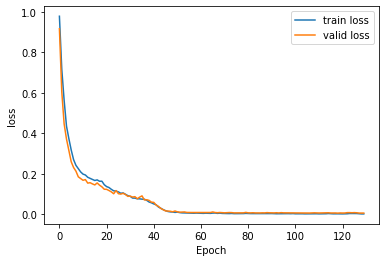

8/8 [==============================] - 1s 4ms/step
Threshold setting...


,Reconstruction_error,True_class
count,249.000000,249.0
mean,0.006133,0.0
std,0.026785,0.0
min,0.000029,0.0
25%,0.000446,0.0
50%,0.000772,0.0
75%,0.001361,0.0
max,0.252198,0.0


Threshold for this process is.. : 0.1552864882004496
Epoch 1/130
24/24 [==============================] - 6s 40ms/step - loss: 0.9706 - val_loss: 1.0103
Epoch 2/130
24/24 [==============================] - 0s 12ms/step - loss: 0.6677 - val_loss: 0.6532
Epoch 3/130
24/24 [==============================] - 0s 13ms/step - loss: 0.5078 - val_loss: 0.5469
Epoch 4/130
24/24 [==============================] - 0s 14ms/step - loss: 0.3886 - val_loss: 0.3887
Epoch 5/130
24/24 [==============================] - 0s 14ms/step - loss: 0.3057 - val_loss: 0.3160
Epoch 6/130
24/24 [==============================] - 0s 15ms/step - loss: 0.2521 - val_loss: 0.2726
Epoch 7/130
24/24 [==============================] - 0s 15ms/step - loss: 0.2280 - val_loss: 0.2394
Epoch 8/130
24/24 [==============================] - 0s 15ms/step - loss: 0.2065 - val_loss: 0.2366
Epoch 9/130
24/24 [==============================] - 0s 15ms/step - loss: 0.1933 - val_loss: 0.2200
Epoch 10/130
24/24 [===========================

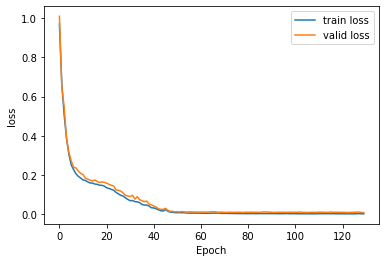

8/8 [==============================] - 1s 4ms/step
Threshold setting...


,Reconstruction_error,True_class
count,249.000000,249.0
mean,0.008744,0.0
std,0.036040,0.0
min,0.000044,0.0
25%,0.000481,0.0
50%,0.000903,0.0
75%,0.002103,0.0
max,0.467519,0.0


Threshold for this process is.. : 0.12746170719333882
Epoch 1/130
20/20 [==============================] - 6s 55ms/step - loss: 0.9890 - val_loss: 0.9452
Epoch 2/130
20/20 [==============================] - 0s 17ms/step - loss: 0.7812 - val_loss: 0.6245
Epoch 3/130
20/20 [==============================] - 0s 15ms/step - loss: 0.6055 - val_loss: 0.5547
Epoch 4/130
20/20 [==============================] - 0s 15ms/step - loss: 0.5106 - val_loss: 0.4855
Epoch 5/130
20/20 [==============================] - 0s 15ms/step - loss: 0.4238 - val_loss: 0.4082
Epoch 6/130
20/20 [==============================] - 0s 15ms/step - loss: 0.3543 - val_loss: 0.3531
Epoch 7/130
20/20 [==============================] - 0s 15ms/step - loss: 0.3038 - val_loss: 0.3258
Epoch 8/130
20/20 [==============================] - 0s 15ms/step - loss: 0.2768 - val_loss: 0.2979
Epoch 9/130
20/20 [==============================] - 0s 15ms/step - loss: 0.2495 - val_loss: 0.2735
Epoch 10/130
20/20 [==========================

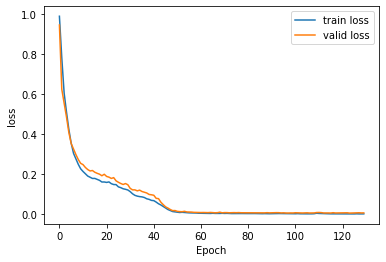

6/6 [==============================] - 1s 4ms/step
Threshold setting...


,Reconstruction_error,True_class
count,177.000000,177.0
mean,0.007103,0.0
std,0.027681,0.0
min,0.000157,0.0
25%,0.000713,0.0
50%,0.001256,0.0
75%,0.002749,0.0
max,0.277389,0.0


Threshold for this process is.. : 0.12483738476138949
Epoch 1/130
18/18 [==============================] - 6s 69ms/step - loss: 0.9812 - val_loss: 0.9706
Epoch 2/130
18/18 [==============================] - 0s 12ms/step - loss: 0.8938 - val_loss: 0.7426
Epoch 3/130
18/18 [==============================] - 0s 14ms/step - loss: 0.6734 - val_loss: 0.6788
Epoch 4/130
18/18 [==============================] - 0s 16ms/step - loss: 0.5807 - val_loss: 0.5677
Epoch 5/130
18/18 [==============================] - 0s 15ms/step - loss: 0.4993 - val_loss: 0.4996
Epoch 6/130
18/18 [==============================] - 0s 16ms/step - loss: 0.4166 - val_loss: 0.4369
Epoch 7/130
18/18 [==============================] - 0s 16ms/step - loss: 0.3552 - val_loss: 0.3910
Epoch 8/130
18/18 [==============================] - 0s 15ms/step - loss: 0.3125 - val_loss: 0.3442
Epoch 9/130
18/18 [==============================] - 0s 15ms/step - loss: 0.2649 - val_loss: 0.3058
Epoch 10/130
18/18 [==========================

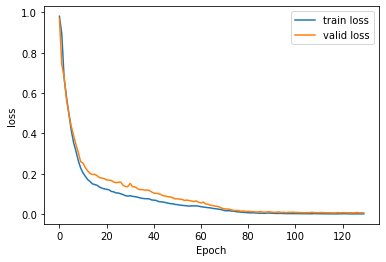

6/6 [==============================] - 1s 5ms/step
Threshold setting...


,Reconstruction_error,True_class
count,177.000000,177.0
mean,0.006365,0.0
std,0.024222,0.0
min,0.000063,0.0
25%,0.000498,0.0
50%,0.001064,0.0
75%,0.002096,0.0
max,0.219123,0.0


Threshold for this process is.. : 0.1164225363985119
Epoch 1/130
21/21 [==============================] - 6s 47ms/step - loss: 0.9801 - val_loss: 0.9655
Epoch 2/130
21/21 [==============================] - 0s 13ms/step - loss: 0.7214 - val_loss: 0.6234
Epoch 3/130
21/21 [==============================] - 0s 15ms/step - loss: 0.5480 - val_loss: 0.5313
Epoch 4/130
21/21 [==============================] - 0s 16ms/step - loss: 0.4829 - val_loss: 0.4623
Epoch 5/130
21/21 [==============================] - 0s 16ms/step - loss: 0.3891 - val_loss: 0.3384
Epoch 6/130
21/21 [==============================] - 0s 16ms/step - loss: 0.3027 - val_loss: 0.2726
Epoch 7/130
21/21 [==============================] - 0s 15ms/step - loss: 0.2615 - val_loss: 0.2505
Epoch 8/130
21/21 [==============================] - 0s 16ms/step - loss: 0.2327 - val_loss: 0.2160
Epoch 9/130
21/21 [==============================] - 0s 15ms/step - loss: 0.2115 - val_loss: 0.1957
Epoch 10/130
21/21 [===========================

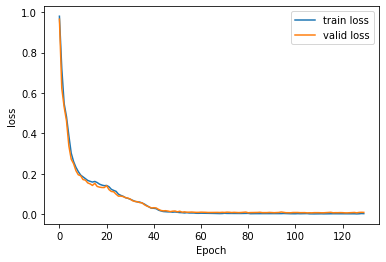

7/7 [==============================] - 1s 11ms/step
Threshold setting...


,Reconstruction_error,True_class
count,213.000000,213.0
mean,0.009577,0.0
std,0.035259,0.0
min,0.000224,0.0
25%,0.001134,0.0
50%,0.002041,0.0
75%,0.003757,0.0
max,0.322981,0.0


Threshold for this process is.. : 0.2110259051391437
Epoch 1/130
18/18 [==============================] - 7s 55ms/step - loss: 0.9823 - val_loss: 0.9655
Epoch 2/130
18/18 [==============================] - 0s 13ms/step - loss: 0.7867 - val_loss: 0.7013
Epoch 3/130
18/18 [==============================] - 0s 15ms/step - loss: 0.6082 - val_loss: 0.5479
Epoch 4/130
18/18 [==============================] - 0s 15ms/step - loss: 0.5099 - val_loss: 0.4848
Epoch 5/130
18/18 [==============================] - 0s 16ms/step - loss: 0.4403 - val_loss: 0.3983
Epoch 6/130
18/18 [==============================] - 0s 17ms/step - loss: 0.3688 - val_loss: 0.3196
Epoch 7/130
18/18 [==============================] - 0s 16ms/step - loss: 0.3176 - val_loss: 0.2742
Epoch 8/130
18/18 [==============================] - 0s 15ms/step - loss: 0.2726 - val_loss: 0.2947
Epoch 9/130
18/18 [==============================] - 0s 17ms/step - loss: 0.2815 - val_loss: 0.2512
Epoch 10/130
18/18 [===========================

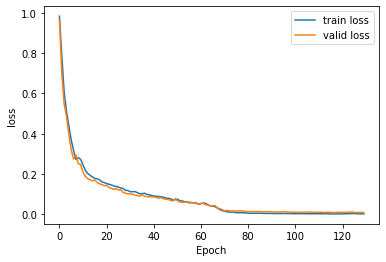

6/6 [==============================] - 1s 4ms/step
Threshold setting...


,Reconstruction_error,True_class
count,177.000000,177.0
mean,0.010088,0.0
std,0.070106,0.0
min,0.000062,0.0
25%,0.000514,0.0
50%,0.000990,0.0
75%,0.001809,0.0
max,0.737449,0.0


Threshold for this process is.. : 0.20157870816911982
Epoch 1/130
18/18 [==============================] - 6s 55ms/step - loss: 0.9860 - val_loss: 1.0208
Epoch 2/130
18/18 [==============================] - 0s 14ms/step - loss: 0.7999 - val_loss: 0.9869
Epoch 3/130
18/18 [==============================] - 0s 15ms/step - loss: 0.5823 - val_loss: 0.6115
Epoch 4/130
18/18 [==============================] - 0s 15ms/step - loss: 0.5086 - val_loss: 0.5450
Epoch 5/130
18/18 [==============================] - 0s 15ms/step - loss: 0.4477 - val_loss: 0.4568
Epoch 6/130
18/18 [==============================] - 0s 16ms/step - loss: 0.3687 - val_loss: 0.3931
Epoch 7/130
18/18 [==============================] - 0s 17ms/step - loss: 0.3084 - val_loss: 0.3351
Epoch 8/130
18/18 [==============================] - 0s 17ms/step - loss: 0.2617 - val_loss: 0.3442
Epoch 9/130
18/18 [==============================] - 0s 16ms/step - loss: 0.2377 - val_loss: 0.2764
Epoch 10/130
18/18 [==========================

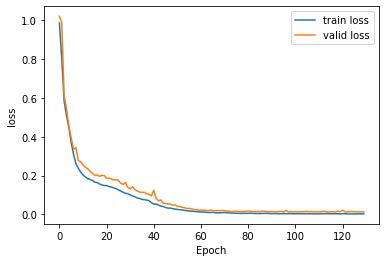

6/6 [==============================] - 1s 4ms/step
Threshold setting...


,Reconstruction_error,True_class
count,177.000000,177.0
mean,0.012649,0.0
std,0.047490,0.0
min,0.000324,0.0
25%,0.000998,0.0
50%,0.001547,0.0
75%,0.002711,0.0
max,0.442160,0.0


Threshold for this process is.. : 0.21536556614308003
Epoch 1/130
21/21 [==============================] - 6s 49ms/step - loss: 0.9793 - val_loss: 0.8312
Epoch 2/130
21/21 [==============================] - 0s 13ms/step - loss: 0.7317 - val_loss: 0.5701
Epoch 3/130
21/21 [==============================] - 0s 14ms/step - loss: 0.5757 - val_loss: 0.5350
Epoch 4/130
21/21 [==============================] - 0s 15ms/step - loss: 0.4921 - val_loss: 0.4201
Epoch 5/130
21/21 [==============================] - 0s 17ms/step - loss: 0.4061 - val_loss: 0.3069
Epoch 6/130
21/21 [==============================] - 0s 16ms/step - loss: 0.3293 - val_loss: 0.2873
Epoch 7/130
21/21 [==============================] - 0s 17ms/step - loss: 0.2634 - val_loss: 0.2779
Epoch 8/130
21/21 [==============================] - 0s 16ms/step - loss: 0.2232 - val_loss: 0.3017
Epoch 9/130
21/21 [==============================] - 0s 16ms/step - loss: 0.2026 - val_loss: 0.2733
Epoch 10/130
21/21 [==========================

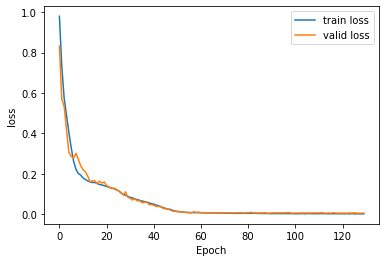

7/7 [==============================] - 1s 4ms/step
Threshold setting...


,Reconstruction_error,True_class
count,213.000000,213.0
mean,0.006756,0.0
std,0.036437,0.0
min,0.000137,0.0
25%,0.000804,0.0
50%,0.001408,0.0
75%,0.002710,0.0
max,0.440846,0.0


Threshold for this process is.. : 0.10535289304584794
Epoch 1/130
21/21 [==============================] - 6s 56ms/step - loss: 0.9811 - val_loss: 0.7754
Epoch 2/130
21/21 [==============================] - 0s 12ms/step - loss: 0.8172 - val_loss: 0.5249
Epoch 3/130
21/21 [==============================] - 0s 13ms/step - loss: 0.6370 - val_loss: 0.4746
Epoch 4/130
21/21 [==============================] - 0s 14ms/step - loss: 0.5636 - val_loss: 0.3968
Epoch 5/130
21/21 [==============================] - 0s 15ms/step - loss: 0.4687 - val_loss: 0.3304
Epoch 6/130
21/21 [==============================] - 0s 15ms/step - loss: 0.4121 - val_loss: 0.2872
Epoch 7/130
21/21 [==============================] - 0s 15ms/step - loss: 0.3565 - val_loss: 0.2531
Epoch 8/130
21/21 [==============================] - 0s 15ms/step - loss: 0.3038 - val_loss: 0.2122
Epoch 9/130
21/21 [==============================] - 0s 15ms/step - loss: 0.2555 - val_loss: 0.1752
Epoch 10/130
21/21 [==========================

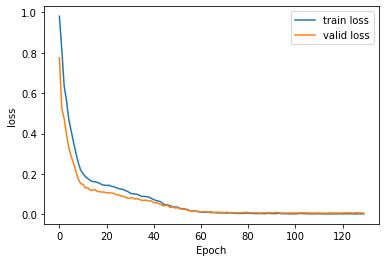

7/7 [==============================] - 1s 5ms/step
Threshold setting...


,Reconstruction_error,True_class
count,213.000000,213.0
mean,0.006169,0.0
std,0.044891,0.0
min,0.000080,0.0
25%,0.000296,0.0
50%,0.000505,0.0
75%,0.001167,0.0
max,0.631993,0.0


Threshold for this process is.. : 0.07490440375352576
Epoch 1/130
21/21 [==============================] - 6s 49ms/step - loss: 0.9832 - val_loss: 0.8361
Epoch 2/130
21/21 [==============================] - 0s 14ms/step - loss: 0.7828 - val_loss: 0.5585
Epoch 3/130
21/21 [==============================] - 0s 15ms/step - loss: 0.5900 - val_loss: 0.4562
Epoch 4/130
21/21 [==============================] - 0s 16ms/step - loss: 0.4973 - val_loss: 0.3753
Epoch 5/130
21/21 [==============================] - 0s 17ms/step - loss: 0.4143 - val_loss: 0.3163
Epoch 6/130
21/21 [==============================] - 0s 17ms/step - loss: 0.3468 - val_loss: 0.2733
Epoch 7/130
21/21 [==============================] - 0s 18ms/step - loss: 0.3040 - val_loss: 0.2269
Epoch 8/130
21/21 [==============================] - 0s 17ms/step - loss: 0.2779 - val_loss: 0.2145
Epoch 9/130
21/21 [==============================] - 0s 17ms/step - loss: 0.2399 - val_loss: 0.1838
Epoch 10/130
21/21 [==========================

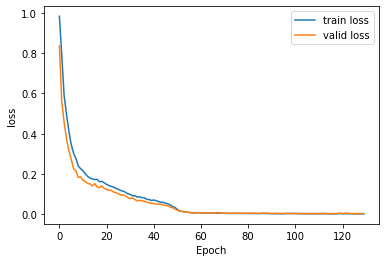

7/7 [==============================] - 1s 4ms/step
Threshold setting...


,Reconstruction_error,True_class
count,213.000000,213.0
mean,0.003921,0.0
std,0.011816,0.0
min,0.000082,0.0
25%,0.000458,0.0
50%,0.000782,0.0
75%,0.001527,0.0
max,0.094937,0.0


Threshold for this process is.. : 0.06458710671416724
Epoch 1/130
21/21 [==============================] - 6s 50ms/step - loss: 0.9849 - val_loss: 1.0680
Epoch 2/130
21/21 [==============================] - 0s 15ms/step - loss: 0.7270 - val_loss: 0.6877
Epoch 3/130
21/21 [==============================] - 0s 16ms/step - loss: 0.5409 - val_loss: 0.5715
Epoch 4/130
21/21 [==============================] - 0s 17ms/step - loss: 0.4398 - val_loss: 0.4763
Epoch 5/130
21/21 [==============================] - 0s 18ms/step - loss: 0.3662 - val_loss: 0.4116
Epoch 6/130
21/21 [==============================] - 0s 18ms/step - loss: 0.3061 - val_loss: 0.3488
Epoch 7/130
21/21 [==============================] - 0s 17ms/step - loss: 0.2607 - val_loss: 0.3147
Epoch 8/130
21/21 [==============================] - 0s 20ms/step - loss: 0.2246 - val_loss: 0.2920
Epoch 9/130
21/21 [==============================] - 0s 19ms/step - loss: 0.2113 - val_loss: 0.2696
Epoch 10/130
21/21 [==========================

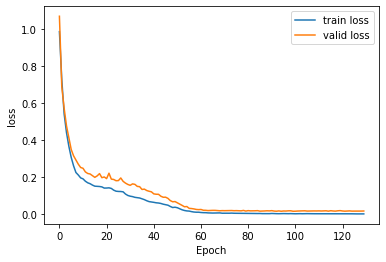

7/7 [==============================] - 1s 4ms/step
Threshold setting...


,Reconstruction_error,True_class
count,213.000000,213.0
mean,0.016918,0.0
std,0.090519,0.0
min,0.000089,0.0
25%,0.000609,0.0
50%,0.001369,0.0
75%,0.003115,0.0
max,0.927348,0.0


Threshold for this process is.. : 0.23128454040649468
Epoch 1/130
23/23 [==============================] - 6s 48ms/step - loss: 0.9763 - val_loss: 0.9870
Epoch 2/130
23/23 [==============================] - 0s 15ms/step - loss: 0.6643 - val_loss: 0.6959
Epoch 3/130
23/23 [==============================] - 0s 17ms/step - loss: 0.9984 - val_loss: 0.6526
Epoch 4/130
23/23 [==============================] - 0s 17ms/step - loss: 0.5248 - val_loss: 0.5730
Epoch 5/130
23/23 [==============================] - 0s 17ms/step - loss: 0.4434 - val_loss: 0.4824
Epoch 6/130
23/23 [==============================] - 0s 20ms/step - loss: 0.5118 - val_loss: 0.4812
Epoch 7/130
23/23 [==============================] - 0s 18ms/step - loss: 0.3718 - val_loss: 0.4409
Epoch 8/130
23/23 [==============================] - 0s 19ms/step - loss: 0.3322 - val_loss: 0.3983
Epoch 9/130
23/23 [==============================] - 0s 18ms/step - loss: 0.3072 - val_loss: 0.3672
Epoch 10/130
23/23 [==========================

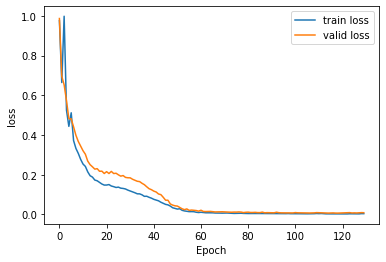

7/7 [==============================] - 1s 4ms/step
Threshold setting...


,Reconstruction_error,True_class
count,213.000000,213.0
mean,0.008376,0.0
std,0.039428,0.0
min,0.000098,0.0
25%,0.000830,0.0
50%,0.001506,0.0
75%,0.003218,0.0
max,0.481230,0.0


Threshold for this process is.. : 0.1710580888209282
Epoch 1/130
21/21 [==============================] - 6s 52ms/step - loss: 0.9827 - val_loss: 0.8230
Epoch 2/130
21/21 [==============================] - 0s 16ms/step - loss: 0.9320 - val_loss: 0.5025
Epoch 3/130
21/21 [==============================] - 0s 18ms/step - loss: 0.5971 - val_loss: 0.4958
Epoch 4/130
21/21 [==============================] - 0s 18ms/step - loss: 0.5474 - val_loss: 0.3624
Epoch 5/130
21/21 [==============================] - 0s 18ms/step - loss: 0.4401 - val_loss: 0.3515
Epoch 6/130
21/21 [==============================] - 0s 17ms/step - loss: 0.3889 - val_loss: 0.2980
Epoch 7/130
21/21 [==============================] - 0s 18ms/step - loss: 0.3462 - val_loss: 0.2690
Epoch 8/130
21/21 [==============================] - 0s 17ms/step - loss: 0.3139 - val_loss: 0.2319
Epoch 9/130
21/21 [==============================] - 0s 18ms/step - loss: 0.2731 - val_loss: 0.1964
Epoch 10/130
21/21 [===========================

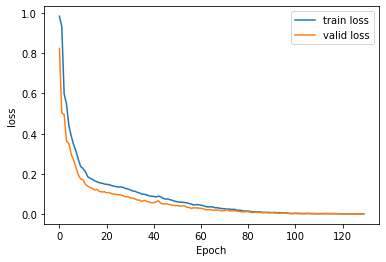

7/7 [==============================] - 1s 4ms/step
Threshold setting...


,Reconstruction_error,True_class
count,213.000000,213.0
mean,0.002061,0.0
std,0.009393,0.0
min,0.000055,0.0
25%,0.000347,0.0
50%,0.000658,0.0
75%,0.001342,0.0
max,0.127493,0.0


Threshold for this process is.. : 0.012155667145755163
Epoch 1/130
18/18 [==============================] - 6s 66ms/step - loss: 0.9862 - val_loss: 0.9454
Epoch 2/130
18/18 [==============================] - 0s 14ms/step - loss: 0.8029 - val_loss: 0.6061
Epoch 3/130
18/18 [==============================] - 0s 15ms/step - loss: 0.5912 - val_loss: 0.5758
Epoch 4/130
18/18 [==============================] - 0s 18ms/step - loss: 0.5219 - val_loss: 0.5110
Epoch 5/130
18/18 [==============================] - 0s 20ms/step - loss: 0.4544 - val_loss: 0.4385
Epoch 6/130
18/18 [==============================] - 0s 18ms/step - loss: 0.3867 - val_loss: 0.3848
Epoch 7/130
18/18 [==============================] - 0s 18ms/step - loss: 0.3296 - val_loss: 0.3316
Epoch 8/130
18/18 [==============================] - 0s 18ms/step - loss: 0.2760 - val_loss: 0.2848
Epoch 9/130
18/18 [==============================] - 0s 18ms/step - loss: 0.2396 - val_loss: 0.2815
Epoch 10/130
18/18 [=========================

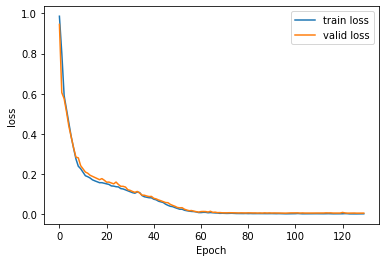

6/6 [==============================] - 1s 5ms/step
Threshold setting...


,Reconstruction_error,True_class
count,177.000000,177.0
mean,0.006232,0.0
std,0.023844,0.0
min,0.000091,0.0
25%,0.000562,0.0
50%,0.001068,0.0
75%,0.002175,0.0
max,0.244239,0.0


Threshold for this process is.. : 0.11219978581359907
Epoch 1/130
20/20 [==============================] - 6s 56ms/step - loss: 0.9792 - val_loss: 0.8832
Epoch 2/130
20/20 [==============================] - 0s 16ms/step - loss: 0.7070 - val_loss: 0.5875
Epoch 3/130
20/20 [==============================] - 0s 17ms/step - loss: 0.5391 - val_loss: 0.4862
Epoch 4/130
20/20 [==============================] - 0s 20ms/step - loss: 0.4345 - val_loss: 0.3958
Epoch 5/130
20/20 [==============================] - 0s 20ms/step - loss: 0.3240 - val_loss: 0.3074
Epoch 6/130
20/20 [==============================] - 0s 18ms/step - loss: 0.2439 - val_loss: 0.2662
Epoch 7/130
20/20 [==============================] - 0s 18ms/step - loss: 0.2193 - val_loss: 0.2494
Epoch 8/130
20/20 [==============================] - 0s 18ms/step - loss: 0.1958 - val_loss: 0.2284
Epoch 9/130
20/20 [==============================] - 0s 19ms/step - loss: 0.1816 - val_loss: 0.2230
Epoch 10/130
20/20 [==========================

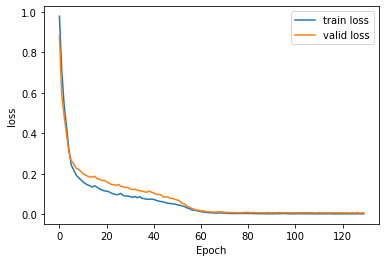

6/6 [==============================] - 1s 5ms/step
Threshold setting...


,Reconstruction_error,True_class
count,177.000000,177.0
mean,0.007092,0.0
std,0.034679,0.0
min,0.000031,0.0
25%,0.000909,0.0
50%,0.001415,0.0
75%,0.002533,0.0
max,0.411207,0.0


Threshold for this process is.. : 0.11482165694910659
Epoch 1/130
20/20 [==============================] - 6s 55ms/step - loss: 0.9807 - val_loss: 0.8803
Epoch 2/130
20/20 [==============================] - 0s 20ms/step - loss: 0.7638 - val_loss: 0.6196
Epoch 3/130
20/20 [==============================] - 0s 20ms/step - loss: 0.5951 - val_loss: 0.5210
Epoch 4/130
20/20 [==============================] - 0s 24ms/step - loss: 0.5127 - val_loss: 0.4640
Epoch 5/130
20/20 [==============================] - 0s 23ms/step - loss: 0.4391 - val_loss: 0.3795
Epoch 6/130
20/20 [==============================] - 0s 22ms/step - loss: 0.3318 - val_loss: 0.3121
Epoch 7/130
20/20 [==============================] - 0s 20ms/step - loss: 0.2887 - val_loss: 0.2950
Epoch 8/130
20/20 [==============================] - 0s 20ms/step - loss: 0.2549 - val_loss: 0.2609
Epoch 9/130
20/20 [==============================] - 0s 22ms/step - loss: 0.2338 - val_loss: 0.2406
Epoch 10/130
20/20 [==========================

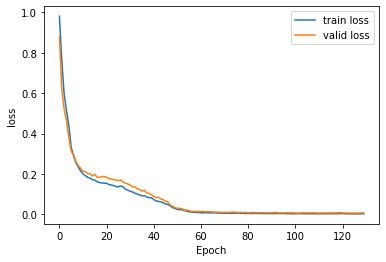

6/6 [==============================] - 1s 4ms/step
Threshold setting...


,Reconstruction_error,True_class
count,177.000000,177.0
mean,0.006562,0.0
std,0.029629,0.0
min,0.000058,0.0
25%,0.000416,0.0
50%,0.000940,0.0
75%,0.002493,0.0
max,0.343004,0.0


Threshold for this process is.. : 0.10155658513150956
Epoch 1/130
23/23 [==============================] - 6s 46ms/step - loss: 0.9752 - val_loss: 0.8902
Epoch 2/130
23/23 [==============================] - 0s 12ms/step - loss: 0.9049 - val_loss: 0.6378
Epoch 3/130
23/23 [==============================] - 0s 15ms/step - loss: 0.6676 - val_loss: 0.5811
Epoch 4/130
23/23 [==============================] - 0s 15ms/step - loss: 0.5527 - val_loss: 0.4036
Epoch 5/130
23/23 [==============================] - 0s 16ms/step - loss: 0.4404 - val_loss: 0.3460
Epoch 6/130
23/23 [==============================] - 0s 15ms/step - loss: 0.3723 - val_loss: 0.2969
Epoch 7/130
23/23 [==============================] - 0s 16ms/step - loss: 0.3087 - val_loss: 0.2369
Epoch 8/130
23/23 [==============================] - 0s 16ms/step - loss: 0.2444 - val_loss: 0.2124
Epoch 9/130
23/23 [==============================] - 0s 16ms/step - loss: 0.2141 - val_loss: 0.1793
Epoch 10/130
23/23 [==========================

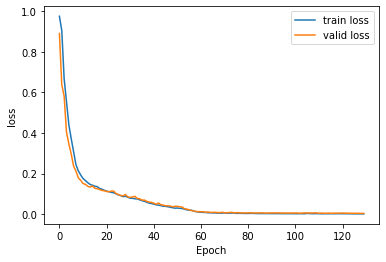

7/7 [==============================] - 1s 4ms/step
Threshold setting...


,Reconstruction_error,True_class
count,213.000000,213.0
mean,0.004158,0.0
std,0.016025,0.0
min,0.000047,0.0
25%,0.000577,0.0
50%,0.000865,0.0
75%,0.001423,0.0
max,0.195403,0.0


Threshold for this process is.. : 0.050345767769884975
Epoch 1/130
23/23 [==============================] - 6s 40ms/step - loss: 0.9668 - val_loss: 0.8206
Epoch 2/130
23/23 [==============================] - 0s 12ms/step - loss: 0.6603 - val_loss: 0.5592
Epoch 3/130
23/23 [==============================] - 0s 14ms/step - loss: 0.5449 - val_loss: 0.4614
Epoch 4/130
23/23 [==============================] - 0s 15ms/step - loss: 0.4550 - val_loss: 0.3654
Epoch 5/130
23/23 [==============================] - 0s 15ms/step - loss: 0.3556 - val_loss: 0.2979
Epoch 6/130
23/23 [==============================] - 0s 15ms/step - loss: 0.2740 - val_loss: 0.2319
Epoch 7/130
23/23 [==============================] - 0s 15ms/step - loss: 0.2309 - val_loss: 0.2029
Epoch 8/130
23/23 [==============================] - 0s 15ms/step - loss: 0.2011 - val_loss: 0.1769
Epoch 9/130
23/23 [==============================] - 0s 16ms/step - loss: 0.1798 - val_loss: 0.1687
Epoch 10/130
23/23 [=========================

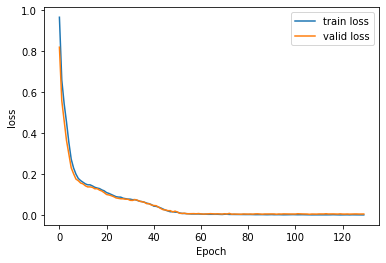

7/7 [==============================] - 1s 4ms/step
Threshold setting...


,Reconstruction_error,True_class
count,213.000000,213.0
mean,0.006277,0.0
std,0.036301,0.0
min,0.000057,0.0
25%,0.000428,0.0
50%,0.000655,0.0
75%,0.001110,0.0
max,0.474949,0.0


Threshold for this process is.. : 0.08253452967017949


In [8]:
from pickle import dump
import pickle

threshold_list = []
for process in range(1,44):
    process_scaler, trained_model, threshold = main(process)
    dump(process_scaler, open('./scaler/Scaler_'+str(process)+'.pkl', 'wb'))
    trained_model.save('./model/LSTMAE_'+str(process)+'.h5')
    threshold_list.append(threshold)
    
with open("threshold_list.pkl","wb") as f:
    pickle.dump(threshold_list, f)